# model 2

In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow.keras as keras
import time

In [3]:
# Load and preprocess MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.expand_dims(X_train, -1).astype("float32") / 255.0
X_test = np.expand_dims(X_test, -1).astype("float32") / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Define original CNN model
def create_original_model():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Compile and train original model
original_model = create_original_model()
original_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [4]:
from keras.utils import plot_model
!pip install pydot

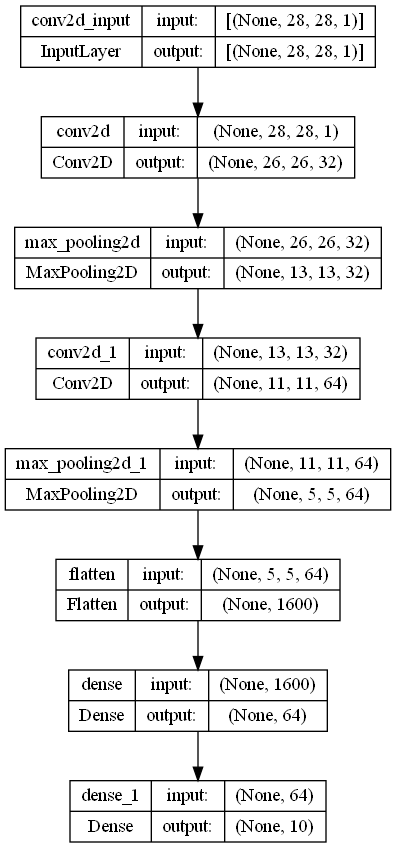

In [6]:
plot_model(original_model, to_file='model_2_mnist_architecture.png', show_shapes=True, show_layer_names=True)

In [4]:
original_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
start_original_time = time.time()
original_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

end_time = time.time()
total_time = end_time - start_original_time 
print(f"Total time: {total_time:.2f} seconds")

Epoch 1/10
1500/1500 [==============================] - 22s 14ms/step - loss: 0.1640 - accuracy: 0.9508 - val_loss: 0.0677 - val_accuracy: 0.9800
Epoch 2/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0519 - accuracy: 0.9844 - val_loss: 0.0515 - val_accuracy: 0.9854
Epoch 3/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0362 - accuracy: 0.9878 - val_loss: 0.0473 - val_accuracy: 0.9860
Epoch 4/10
1500/1500 [==============================] - 22s 14ms/step - loss: 0.0262 - accuracy: 0.9915 - val_loss: 0.0410 - val_accuracy: 0.9879
Epoch 5/10
1500/1500 [==============================] - 25s 17ms/step - loss: 0.0208 - accuracy: 0.9931 - val_loss: 0.0386 - val_accuracy: 0.9888
Epoch 6/10
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0140 - accuracy: 0.9954 - val_loss: 0.0447 - val_accuracy: 0.9890
Epoch 7/10
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0129 - accuracy: 0.9958 - val_loss: 0.0396 -

In [5]:
# Evaluate original model
original_loss, original_accuracy = original_model.evaluate(X_test, y_test)
print(f"Original Model Accuracy: {original_accuracy}, Loss: {original_loss}")

313/313 [==============================] - 2s 6ms/step - loss: 0.0380 - accuracy: 0.9915
Original Model Accuracy: 0.9915000200271606, Loss: 0.03797163441777229


In [6]:
import os

# model_save_path = 'cnn_model.h5'
model_save_path = 'model2.keras'
original_model.save(model_save_path)

# Get the size of the model in bytes
model_size = os.path.getsize(model_save_path)
print(f"Model size: {model_size / 1024:.2f} KB")

Model size: 1473.87 KB


# Pruning

In [7]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot  # TensorFlow Model Optimization toolkit

In [8]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {
      # 'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.1, begin_step=0, frequency=100)
  }

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

pruned_model = prune_low_magnitude(original_model, **pruning_params)

# Use smaller learning rate for fine-tuning
opt = keras.optimizers.Adam()

pruned_model.compile(
  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy']
)

pruned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 32)       610       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 11, 11, 64)       36930     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 5, 5, 64)         1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                        

In [9]:
start_pruning_time = time.time()
pruned_model.fit(
  X_train,
  y_train,
  epochs=10,
  validation_split=0.2,
  callbacks=callbacks)

end_time = time.time()
total_time = end_time - start_pruning_time 
print(f"Total time: {total_time:.2f} seconds")

Epoch 1/10


C:\Users\User\anaconda3\envs\digit-recognition\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1500/1500 [==============================] - 26s 15ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.0631 - val_accuracy: 0.9875
Epoch 2/10
1500/1500 [==============================] - 22s 15ms/step - loss: 0.0055 - accuracy: 0.9980 - val_loss: 0.0552 - val_accuracy: 0.9895
Epoch 3/10
1500/1500 [==============================] - 22s 15ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0522 - val_accuracy: 0.9907
Epoch 4/10
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0501 - val_accuracy: 0.9912
Epoch 5/10
1500/1500 [==============================] - 22s 15ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0515 - val_accuracy: 0.9910
Epoch 6/10
1500/1500 [==============================] - 22s 15ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0771 - val_accuracy: 0.9873
Epoch 7/10
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0627 - val_accura

In [10]:
# Evaluate the model on the test data
pruned_test_loss, pruned_test_acc = pruned_model.evaluate(X_test, y_test)

print(f"Test accuracy: {pruned_test_acc}")

313/313 [==============================] - 2s 6ms/step - loss: 0.0544 - accuracy: 0.9902
Test accuracy: 0.9901999831199646


In [11]:
model_save_path = 'cnn_pruned_model2.keras'
pruned_model.save(model_save_path)

# Get the size of the model in bytes
model_size = os.path.getsize(model_save_path)
print(f"Model size after pruning: {model_size / 1024:.2f} KB")

Model size after pruning: 1962.79 KB


In [12]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
tflite_model = converter.convert()

# Save the TFLite model to a file
model_save_path = 'pruned_model2.tflite'
with open('pruned_model2.tflite', 'wb') as f:
    f.write(tflite_model)

model_size = os.path.getsize(model_save_path)
print(f"Model size after pruning + convert to tf lite: {model_size / 1024:.2f} KB")

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp_7yohtox\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp_7yohtox\assets


Model size after pruning + convert to tf lite: 479.61 KB


# Quantization

In [13]:
# Strip the pruning wrappers to finalize the pruned model
final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# Convert to TensorFlow Lite model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)

# Set quantization parameters
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Default optimization includes quantization

# Optionally, if you have representative data, you can enable full integer quantization:
# Provide a representative dataset for better accuracy in quantization
def representative_dataset():
    for data in X_test.take(100):  # use a small sample of your data <<< what if we change this to 1000? to all data? 70rb? how?
        yield [tf.dtypes.cast(data, tf.float32)] # can we change this to integer?

converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.float16]  # This can be int8 as well, hm... << nope, error

# Convert the model
quantized_tflite_model = converter.convert()

# Save the quantized model to a file
with open('quantized_pruned_model2.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

# To load and use the TFLite model later:
interpreter = tf.lite.Interpreter(model_path='quantized_pruned_model2.tflite')
interpreter.allocate_tensors()

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpyp4e977f\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpyp4e977f\assets


In [14]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [15]:
final_model.compile(
  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy']
)

In [16]:
start_quantization_time = time.time()
final_model.fit(
  X_train,
  y_train,
  epochs=10,
  validation_split=0.2,
  callbacks=callbacks)

end_time = time.time()
total_time = end_time - start_quantization_time 
print(f"Total time: {total_time:.2f} seconds")

Epoch 1/10


C:\Users\User\anaconda3\envs\digit-recognition\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1500/1500 [==============================] - 22s 14ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.0584 - val_accuracy: 0.9909
Epoch 2/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0648 - val_accuracy: 0.9898
Epoch 3/10
1500/1500 [==============================] - 20s 14ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0649 - val_accuracy: 0.9912
Epoch 4/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0671 - val_accuracy: 0.9895
Epoch 5/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 0.0641 - val_accuracy: 0.9903
Epoch 6/10
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 0.0776 - val_accuracy: 0.9888
Epoch 7/10
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0611 - val_accura

In [17]:
# Evaluate the model on the test data
quantization_test_loss, quantization_test_acc = final_model.evaluate(X_test, y_test)

print(f"Test accuracy: {quantization_test_acc}")

313/313 [==============================] - 3s 7ms/step - loss: 0.0606 - accuracy: 0.9913
Test accuracy: 0.9912999868392944


In [18]:
model_size = os.path.getsize('quantized_pruned_model2.tflite')
print(f"Model size after quantization: {model_size / 1024:.2f} KB")

Model size after quantization: 242.58 KB


# Optimized Model with Knowledge Distillation

In [22]:
# Custom loss function for Knowledge Distillation
def distillation_loss(y_true, y_pred, teacher_logits, temperature=5.0, alpha=0.5):
    student_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    distillation_loss = tf.keras.losses.KLDivergence()(
        tf.nn.softmax(teacher_logits / temperature),
        tf.nn.softmax(y_pred / temperature)
    )
    return alpha * student_loss + (1 - alpha) * distillation_loss

# Train student model with teacher model's logits
def train_student_model(student_model, teacher_model, X_train, y_train):
    teacher_logits = teacher_model.predict(X_train)

    # Custom training loop
    start_kd_time = time.time()    
    for epoch in range(10):
        print(f"Epoch {epoch + 1}/10")
        epoch_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for i in range(0, len(X_train), 32):
            X_batch = X_train[i:i+32]
            y_batch = y_train[i:i+32]
            with tf.GradientTape() as tape:
                y_pred = student_model(X_batch, training=True)
                loss = distillation_loss(y_batch, y_pred, teacher_logits[i:i+32])
            grads = tape.gradient(loss, student_model.trainable_variables)
            student_model.optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

            # Track loss and accuracy
            epoch_loss += loss.numpy().sum() * len(y_batch)  # Ensure loss is a scalar
            correct_predictions += np.sum(np.argmax(y_pred.numpy(), axis=-1) == np.argmax(y_batch, axis=-1))
            total_predictions += len(y_batch)

        average_loss = epoch_loss / total_predictions
        accuracy = correct_predictions / total_predictions
        print(f"Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

    end_time = time.time()
    total_time = end_time - start_kd_time 
    print(f"Total time: {total_time:.2f} seconds")

# Train the student model
student_model = original_model
train_student_model(student_model, final_model, X_train, y_train)

1875/1875 [==============================] - 10s 5ms/step
Epoch 1/10
Loss: 0.0557, Accuracy: 0.9991
Epoch 2/10
Loss: 0.0498, Accuracy: 0.9990
Epoch 3/10
Loss: 0.0327, Accuracy: 0.9995
Epoch 4/10
Loss: 0.0487, Accuracy: 0.9991
Epoch 5/10
Loss: 0.0358, Accuracy: 0.9994
Epoch 6/10
Loss: 0.0363, Accuracy: 0.9994
Epoch 7/10
Loss: 0.0544, Accuracy: 0.9991
Epoch 8/10
Loss: 0.0335, Accuracy: 0.9993
Epoch 9/10
Loss: 0.0493, Accuracy: 0.9992
Epoch 10/10
Loss: 0.0261, Accuracy: 0.9995
Total time: 722.30 seconds


In [23]:
# Evaluate student model
student_loss, student_accuracy = student_model.evaluate(X_test, y_test)
print(f"Student Model Accuracy: {student_accuracy}, Loss: {student_loss}")

313/313 [==============================] - 2s 5ms/step - loss: 0.0725 - accuracy: 0.9921
Student Model Accuracy: 0.9921000003814697, Loss: 0.07250040769577026


In [24]:
# model_save_path = 'cnn_model.h5'
model_save_path = 'student_model2.keras'
student_model.save(model_save_path)

# Get the size of the model in bytes
model_size = os.path.getsize(model_save_path)
print(f"Model size: {model_size / 1024:.2f} KB")

Model size: 1473.87 KB
